In [1]:
import sklearn
import sklearn.model_selection
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import json

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
from keras.models import model_from_json

In [41]:
Xsig = np.load("/Users/joosep/Documents/jlr/data/numpy/cms_tth_1l/flat_nokin.npy")
Xsig_mem = np.load("/Users/joosep/Documents/jlr/data/numpy/cms_tth_1l/mem.npy")
evdesc_sig = np.load("/Users/joosep/Documents/jlr/data/numpy/cms_tth_1l/evdesc.npy")

idx_valid_sig = np.load("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/idx_valid.npy")
idx_train_sig = np.load("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/idx_train.npy")

Xbkg = np.load("/Volumes/Samsung_T3/jlr/numpy/cms_ttjets_1l/flat_nokin.npy")
Xbkg_mem = np.load("/Volumes/Samsung_T3/jlr/numpy/cms_ttjets_1l/mem.npy")
evdesc_bkg = np.load("/Volumes/Samsung_T3/jlr/numpy/cms_ttjets_1l/evdesc.npy")

In [42]:
mem_disc_sig = Xsig_mem[:, 0] / (Xsig_mem[:, 0] + 0.1*Xsig_mem[:, 1])
mem_disc_sig[np.isnan(mem_disc_sig)] = 0

mem_disc_bkg = Xbkg_mem[:, 0] / (Xbkg_mem[:, 0] + 0.1*Xbkg_mem[:, 1])
mem_disc_bkg[np.isnan(mem_disc_bkg)] = 0

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


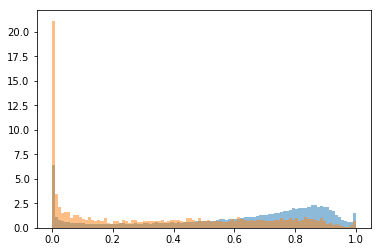

In [43]:
plt.hist(mem_disc_sig[mem_disc_sig>0], bins=100, density=1.0, alpha=0.5);
plt.hist(mem_disc_bkg[mem_disc_bkg>0], bins=100, density=1.0, alpha=0.5);

In [44]:
sig_sel_valid = np.zeros((len(Xsig),), dtype=np.bool)
sig_sel_valid[idx_valid_sig] = True

In [45]:
evdesc_sig.shape, evdesc_bkg.shape

((1066184, 6), (7198820, 6))

In [46]:
f = open("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/model.json").read()
model = model_from_json(f)

In [47]:
model.load_weights("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/model.hdf5")

In [48]:
ysig = model.predict(Xsig, batch_size=10000)
ybkg = model.predict(Xbkg, batch_size=10000)

Text(0,0.5,'fraction of events (a.u.)')

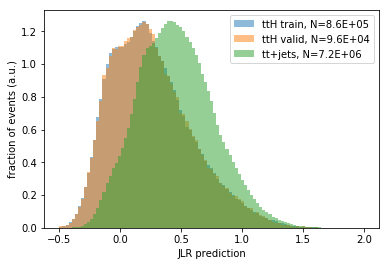

In [49]:
plt.hist(ysig[idx_train_sig], bins=np.linspace(-0.5,2,100), density=1.0, alpha=0.5, label="ttH train, N={0:.1E}".format(len(idx_train_sig)));
plt.hist(ysig[idx_valid_sig], bins=np.linspace(-0.5,2,100), density=1.0, alpha=0.5, label="ttH valid, N={0:.1E}".format(len(idx_valid_sig)));
plt.hist(ybkg, bins=np.linspace(-0.5,2,100), density=1.0, alpha=0.5, label="tt+jets, N={0:.1E}".format(len(ybkg)));
plt.legend()
plt.xlabel("JLR prediction")
plt.ylabel("fraction of events (a.u.)")

In [50]:
def cumhist(y, bins):
    h, _ = np.histogram(y, bins)
    ch = np.cumsum(h)/float(np.sum(h))
    return ch

def calc_roc(ysig, ybkg, bins):
    hs = cumhist(ysig, bins)
    hb = cumhist(ybkg, bins)
    
    return hs, hb

Text(0.5,0,'num_jets')

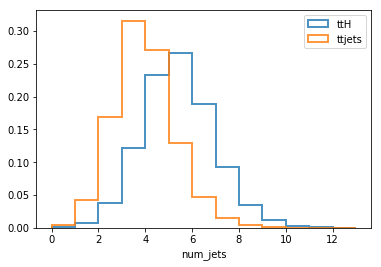

In [60]:
plt.hist(evdesc_sig[:, 1], bins=np.arange(0,14), density=1, alpha=0.8, label="ttH", histtype="step", lw=2);
plt.hist(evdesc_bkg[:, 1], bins=np.arange(0,14), density=1, alpha=0.8, label="ttjets", histtype="step", lw=2);
plt.legend()
plt.xlabel("num_jets")

Text(0.5,0,'nBDeepCSVM')

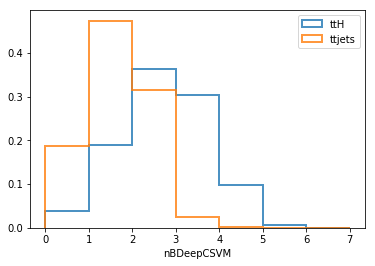

In [61]:
plt.hist(evdesc_sig[:, 2], bins=np.arange(0,8), density=1, alpha=0.8, label="ttH", histtype="step", lw=2);
plt.hist(evdesc_bkg[:, 2], bins=np.arange(0,8), density=1, alpha=0.8, label="ttjets", histtype="step", lw=2);
plt.legend()
plt.xlabel("nBDeepCSVM")

In [92]:
def plot_roc(njets, ntags, do_match=False, nMatch_wq=0, nMatch_tb=0, nMatch_hb=0):
    sig_sel = ((evdesc_sig[:, 0]==1) & (evdesc_sig[:, 1]==njets) & (evdesc_sig[:, 2]==ntags))
    bkg_sel = ((evdesc_bkg[:, 0]==1) & (evdesc_bkg[:, 1]==njets) & (evdesc_bkg[:, 2]==ntags))

    sig_sel_match = ((evdesc_sig[:, 0]==1) & (evdesc_sig[:, 1]==njets) & (evdesc_sig[:, 2]==ntags) & (evdesc_sig[:, 3]==nMatch_wq) & (evdesc_sig[:, 4]==nMatch_tb) & (evdesc_sig[:, 5]==nMatch_hb))
    bkg_sel_match = ((evdesc_bkg[:, 0]==1) & (evdesc_bkg[:, 1]==njets) & (evdesc_bkg[:, 2]==ntags) & (evdesc_bkg[:, 3]==nMatch_wq) & (evdesc_bkg[:, 4]==nMatch_tb))

    plt.figure(figsize=(4,4))
    
    plt.hist(-ysig[sig_sel & sig_sel_valid], bins=np.linspace(-2,0.5,20), density=1.0, alpha=0.5, label="ttH(bb) N={0}".format(np.sum(sig_sel & sig_sel_valid)));
    plt.hist(-ybkg[bkg_sel], bins=np.linspace(-2,0.5,20), density=1.0, alpha=0.5, label="tt+jets N={0}".format(np.sum(bkg_sel)));
    
    if do_match:
        plt.hist(-ysig[sig_sel_match & sig_sel_valid], bins=np.linspace(-2,0.5,20), density=1.0, label="ttH(bb) matched N={0}".format(np.sum(sig_sel_match & sig_sel_valid)), histtype="step", color="blue", lw=2);
        plt.hist(-ybkg[bkg_sel_match], bins=np.linspace(-2,0.5,20), density=1.0, label="tt+jets matched N={0}".format(np.sum(bkg_sel_match)), histtype="step", color="orange", lw=2);
    
    plt.legend()
    plt.xlabel("-JLR prediction")
    
    plt.figure(figsize=(4,4))
    
    hs1, hb1 = calc_roc(-ysig[sig_sel & sig_sel_valid], -ybkg[bkg_sel], np.linspace(-2,0.5,100))
    hs2, hb2 = calc_roc(-ysig[sig_sel_match & sig_sel_valid], -ybkg[bkg_sel_match], np.linspace(-2,0.5,100))

    plt.figure(figsize=(4,4))
    plt.plot(1.0 - hs1, 1.0 - hb1, label="ffwd AUC={0:.4f}".format(sklearn.metrics.auc(1.0 - hs1, 1.0 - hb1)), color="black")
    if do_match:
        plt.plot(1.0 - hs2, 1.0 - hb2, label="ffwd match, AUC={0:.4f}".format(sklearn.metrics.auc(1.0 - hs2, 1.0 - hb2)), color="green")

    plt.plot([0,1],[0,1], color="black", lw=1.0, ls="--")
    plt.legend(loc="best")
    plt.xlabel("signal efficiency")
    plt.ylabel("bkg efficiency")
    plt.xlim(0,1)
    plt.ylim(0,1)

In [97]:
def plot_roc_mem(njets, ntags, do_match=False, nMatch_wq=0, nMatch_tb=0, nMatch_hb=0):
    sig_sel = ((evdesc_sig[:, 0]==1) & (evdesc_sig[:, 1]==njets) & (evdesc_sig[:, 2]==ntags))
    bkg_sel = ((evdesc_bkg[:, 0]==1) & (evdesc_bkg[:, 1]==njets) & (evdesc_bkg[:, 2]==ntags))

    sig_sel_match = ((evdesc_sig[:, 0]==1) & (evdesc_sig[:, 1]==njets) & (evdesc_sig[:, 2]==ntags) & (evdesc_sig[:, 3]==nMatch_wq) & (evdesc_sig[:, 4]==nMatch_tb) & (evdesc_sig[:, 5]==nMatch_hb))
    bkg_sel_match = ((evdesc_bkg[:, 0]==1) & (evdesc_bkg[:, 1]==njets) & (evdesc_bkg[:, 2]==ntags) & (evdesc_bkg[:, 3]==nMatch_wq) & (evdesc_bkg[:, 4]==nMatch_tb))

    plt.figure(figsize=(4,4))
    
    plt.hist(mem_disc_sig[sig_sel & sig_sel_valid], bins=np.linspace(0,1,20), density=1.0, alpha=0.5, label="ttH(bb) N={0}".format(np.sum(sig_sel & sig_sel_valid)));
    plt.hist(mem_disc_bkg[bkg_sel], bins=np.linspace(0,1,20), density=1.0, alpha=0.5, label="tt+jets N={0}".format(np.sum(bkg_sel)));
    
    if do_match:
        plt.hist(mem_disc_sig[sig_sel_match & sig_sel_valid], bins=np.linspace(0,1,20), density=1.0, label="ttH(bb) matched N={0}".format(np.sum(sig_sel_match & sig_sel_valid)), histtype="step", color="blue", lw=2);
        plt.hist(mem_disc_bkg[bkg_sel_match], bins=np.linspace(0,1,20), density=1.0, label="tt+jets matched N={0}".format(np.sum(bkg_sel_match)), histtype="step", color="orange", lw=2);

    plt.legend()

    plt.ylabel("fraction of events (a.u.)")
    plt.xlabel("MEM discriminator")
    
    plt.figure(figsize=(4,4))
    
    hs1, hb1 = calc_roc(mem_disc_sig[sig_sel & sig_sel_valid], mem_disc_bkg[bkg_sel], np.linspace(-0.5,1.5,1000))
    hs2, hb2 = calc_roc(mem_disc_sig[sig_sel_match & sig_sel_valid], mem_disc_bkg[bkg_sel_match], np.linspace(-0.5,1.5,1000))

    plt.figure(figsize=(4,4))
    plt.plot(1.0 - hs1, 1.0 - hb1, label="ffwd AUC={0:.4f}".format(sklearn.metrics.auc(1.0 - hs1, 1.0 - hb1)), color="black")
    if do_match:
        plt.plot(1.0 - hs2, 1.0 - hb2, label="ffwd match, AUC={0:.4f}".format(sklearn.metrics.auc(1.0 - hs2, 1.0 - hb2)), color="green")

    plt.plot([0,1],[0,1], color="black", lw=1.0, ls="--")
    plt.legend(loc="best")
    plt.xlabel("ttH(bb) efficiency")
    plt.ylabel("tt+jets efficiency")
    plt.xlim(0,1)
    plt.ylim(0,1)

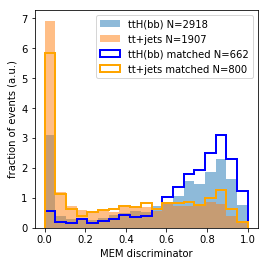

<Figure size 288x288 with 0 Axes>

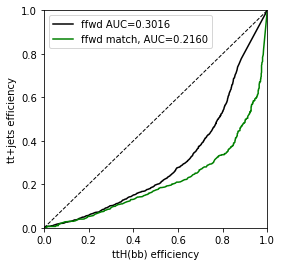

In [98]:
plot_roc_mem(6,4, True, 2, 2, 2)

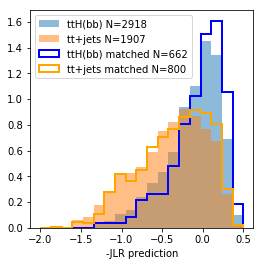

<Figure size 288x288 with 0 Axes>

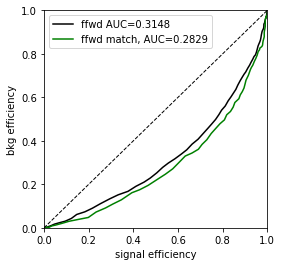

In [99]:
plot_roc(6, 4, True, 2, 2, 2)

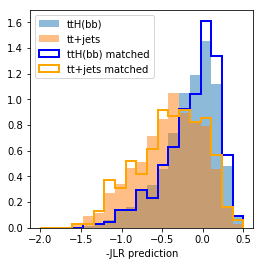

<Figure size 288x288 with 0 Axes>

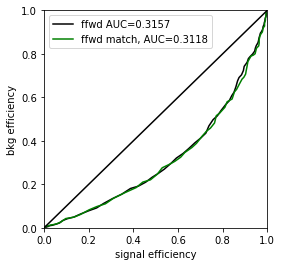

In [78]:
plot_roc(7, 4, True, 2, 2, 2)

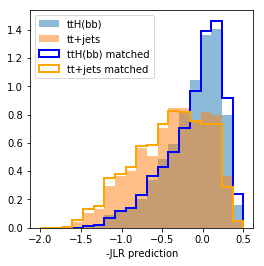

<Figure size 288x288 with 0 Axes>

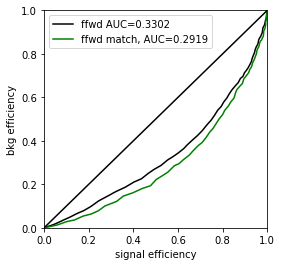

In [79]:
plot_roc(5, 4, True, 1, 2, 2)

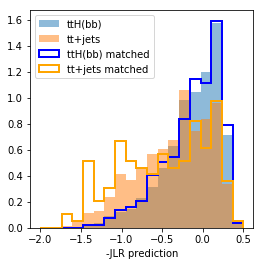

<Figure size 288x288 with 0 Axes>

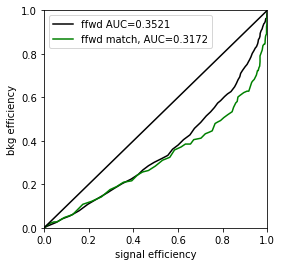

In [81]:
plot_roc(4, 4, True, 0, 2, 2)

In [75]:
metrics = pd.read_csv("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/metrics.csv")

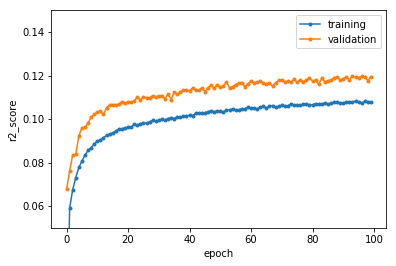

In [76]:
plt.plot(metrics["r2_score0"], label="training", marker=".")
plt.plot(metrics["val_r2_score0"], label="validation", marker=".")
plt.ylim(0.05, 0.15)
plt.xlabel("epoch")
plt.ylabel("r2_score")
plt.legend()
plt.savefig("/Users/joosep/Desktop/epoch.png")